## Import Packages

In [1]:
#File Loading
from zipfile import ZipFile

#Data Manipulation & Visualization
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#Data Preprocessing
from sklearn.impute import SimpleImputer
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import LabelEncoder
from statsmodels.stats.outliers_influence import variance_inflation_factor

#Predictive Modeling
from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb

from sklearn.metrics import *

from sklearn.ensemble import ExtraTreesClassifier

import warnings
warnings.filterwarnings('ignore')

# import requests

## Loading & Exploring Data

In [2]:
#unzipping the file, and load the text file as JSON type
with ZipFile("transactions.zip") as z:
    with z.open("transactions.txt") as file:
        card_txn = pd.read_json(file, lines=True)

In [3]:
#show all columns, and first 3 rows
pd.set_option('display.max_columns',None)
card_txn.head(3)

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,currentExpDate,accountOpenDate,dateOfLastAddressChange,cardCVV,enteredCVV,cardLast4Digits,transactionType,echoBuffer,currentBalance,merchantCity,merchantState,merchantZip,cardPresent,posOnPremises,recurringAuthInd,expirationDateKeyInMatch,isFraud
0,737265056,737265056,5000,5000.0,2016-08-13T14:27:32,98.55,Uber,US,US,02,01,rideshare,06/2023,2015-03-14,2015-03-14,414,414,1803,PURCHASE,,0.0,,,,False,,,False,False
1,737265056,737265056,5000,5000.0,2016-10-11T05:05:54,74.51,AMC #191138,US,US,09,01,entertainment,02/2024,2015-03-14,2015-03-14,486,486,767,PURCHASE,,0.0,,,,True,,,False,False
2,737265056,737265056,5000,5000.0,2016-11-08T09:18:39,7.47,Play Store,US,US,09,01,mobileapps,08/2025,2015-03-14,2015-03-14,486,486,767,PURCHASE,,0.0,,,,False,,,False,False


In [4]:
print('The dataset has', card_txn.shape[0], 'rows and', card_txn.shape[1], 'columns.')

The dataset has 786363 rows and 29 columns.


In [5]:
#check data types of each columns
card_txn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 786363 entries, 0 to 786362
Data columns (total 29 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   accountNumber             786363 non-null  int64  
 1   customerId                786363 non-null  int64  
 2   creditLimit               786363 non-null  int64  
 3   availableMoney            786363 non-null  float64
 4   transactionDateTime       786363 non-null  object 
 5   transactionAmount         786363 non-null  float64
 6   merchantName              786363 non-null  object 
 7   acqCountry                786363 non-null  object 
 8   merchantCountryCode       786363 non-null  object 
 9   posEntryMode              786363 non-null  object 
 10  posConditionCode          786363 non-null  object 
 11  merchantCategoryCode      786363 non-null  object 
 12  currentExpDate            786363 non-null  object 
 13  accountOpenDate           786363 non-null  o

In [6]:
#check statistical summary of numerical columns
card_txn.describe().round(2)

,accountNumber,customerId,creditLimit,availableMoney,transactionAmount,cardCVV,enteredCVV,cardLast4Digits,currentBalance
count,7.863630e+05,7.863630e+05,786363.00,786363.00,786363.00,786363.00,786363.00,786363.00,786363.00
mean,5.372326e+08,5.372326e+08,10759.46,6250.73,136.99,544.47,544.18,4757.42,4508.74
std,2.554211e+08,2.554211e+08,11636.17,8880.78,147.73,261.52,261.55,2996.58,6457.44
min,1.000881e+08,1.000881e+08,250.00,-1005.63,0.00,100.00,0.00,0.00,0.00
25%,3.301333e+08,3.301333e+08,5000.00,1077.42,33.65,310.00,310.00,2178.00,689.91
50%,5.074561e+08,5.074561e+08,7500.00,3184.86,87.90,535.00,535.00,4733.00,2451.76
75%,7.676200e+08,7.676200e+08,15000.00,7500.00,191.48,785.00,785.00,7338.00,5291.10
max,9.993896e+08,9.993896e+08,50000.00,50000.00,2011.54,998.00,998.00,9998.00,47498.81


Everything looks good, nothing is too suspicious. However all datetime columns have to be changed to timestamp data type.

In [7]:
#convert datetime columns into timestamp data type
datetime_col=['transactionDateTime','currentExpDate','accountOpenDate','dateOfLastAddressChange']
for col in datetime_col:
    card_txn[col]=pd.to_datetime(card_txn[col])
    print(col)
    print('Min: ',min(card_txn[col]),'\nMax: ', max(card_txn[col]))

transactionDateTime
Min:  2016-01-01 00:01:02 
Max:  2016-12-30 23:59:45
currentExpDate
Min:  2019-12-01 00:00:00 
Max:  2033-08-01 00:00:00
accountOpenDate
Min:  1989-08-22 00:00:00 
Max:  2015-12-31 00:00:00
dateOfLastAddressChange
Min:  1989-08-22 00:00:00 
Max:  2016-12-30 00:00:00


We are having different ranges of datetime for each datetime column. Nothing special from these values.

In [8]:
#Check if accountNumber and customerId is the same
card_txn['accountNumber'].equals(card_txn['customerId'])

True

`accountNumber` and `customerId` are identical columns. Consider dropping one of them.

In [9]:
#check for empty values in each columns
empty=card_txn.eq('').sum()
empty=empty[empty!=0]
print('Categorical variables that have missing values: \n')
print(empty)

Categorical variables that have missing values: 

acqCountry               4562
merchantCountryCode       724
posEntryMode             4054
posConditionCode          409
transactionType           698
echoBuffer             786363
merchantCity           786363
merchantState          786363
merchantZip            786363
posOnPremises          786363
recurringAuthInd       786363
dtype: int64


There are columns with some missing values, at ~0.6% of the total data maximum. They will be imputed in the next steps. Completely empty columns will be dropped.

### Empty Values Removal & Imputation

In [10]:
#removing empty columns
empty_col=empty[empty==card_txn.shape[0]].index
card_txn=card_txn.drop(empty_col, axis=1)

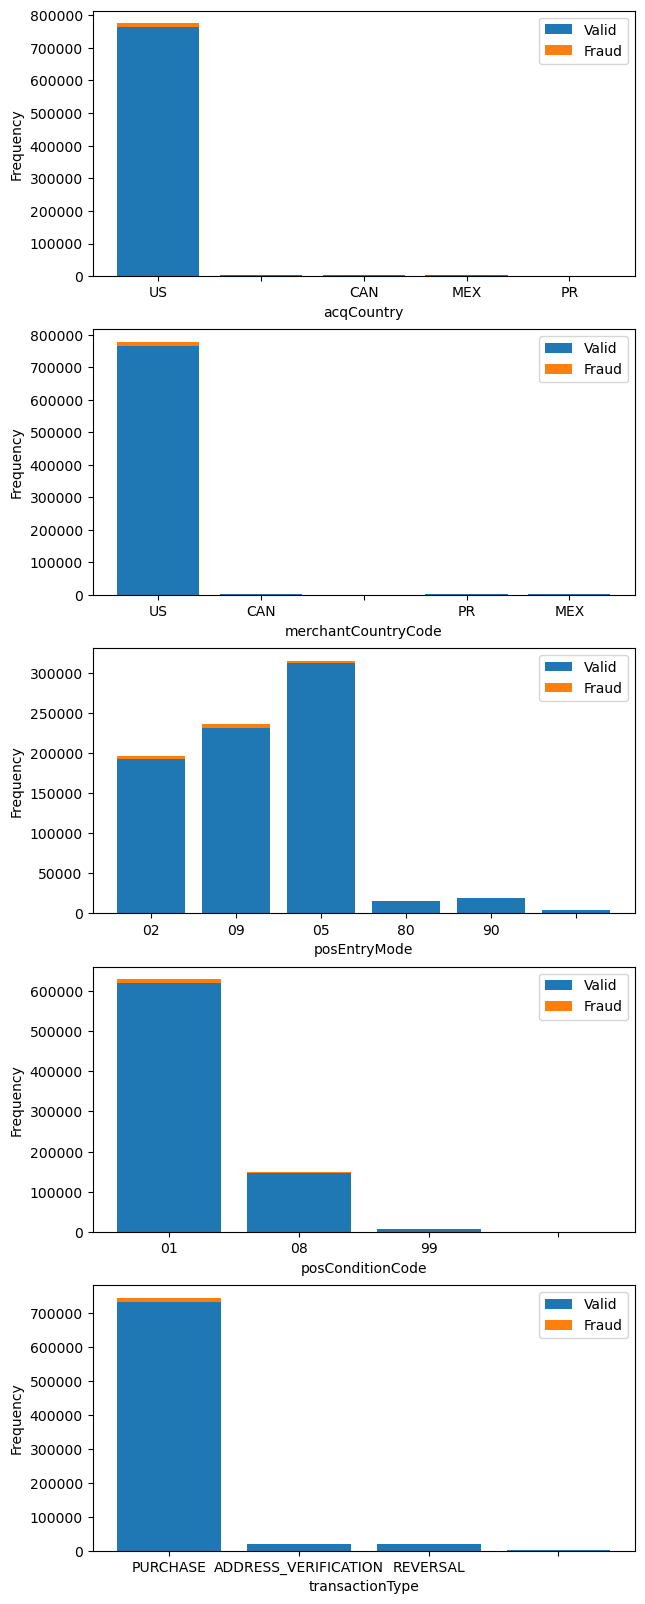

In [11]:
### IMPUTATION #### 
#plotting frequency of columns that have missing values
missing_val_col=['acqCountry','merchantCountryCode','posEntryMode','posConditionCode','transactionType']

fig, axs = plt.subplots(nrows=5,figsize=(7,20))

# index through the missing columns above and the subplots
for col,i in zip(missing_val_col,range(len(missing_val_col))):
    #create a series grouped by the columns to count the occurences of 
    #True and False from the target variable isFraud
    counts=card_txn.groupby([col,'isFraud'])['isFraud'].count()
    counts=counts.unstack(level=1)
    
    # Sort counts indices in the same order as unique values of the column
    counts = counts.loc[card_txn[col].unique()]
    
    #Plot stacked columnm chart, with fraud txn on top of valid ones
    axs[i].bar(card_txn[col].unique(),counts[False],bottom=None,label='Valid')
    axs[i].bar(card_txn[col].unique(),counts[True],bottom=counts[False],label='Fraud')
    axs[i].legend()
    axs[i].set_xlabel(col)
    axs[i].set_ylabel('Frequency')

- Most transactions are: 
    - from the US
    - purchases
    - have the 01 posConditionCode
    - either 02, 05, or 09 posEntryMode
 
Since each column has its dominant values, we can safely proceed to impute missing values with the most frequent one.

In [12]:
#Imputing the missing values with most frequent category using SimpleImputer
for col in missing_val_col:
    card_txn[col]=SimpleImputer(missing_values='',strategy ='most_frequent').fit_transform(card_txn[col].values.reshape(-1,1))

### Unique Values

In [13]:
#check for number of unique records in each columns
unique=card_txn.nunique()
print('Categorical variables that have fewer\n or 5 unique values values: \n')
print(unique[(unique<=5)])

for col in card_txn.columns:
    if((card_txn[col].nunique() <= 5) and (card_txn[col].nunique() > 2)):
        print(card_txn[col].value_counts())
        print(card_txn[col].mode())
        print("\n")

Categorical variables that have fewer
 or 5 unique values values: 

acqCountry                  4
merchantCountryCode         4
posEntryMode                5
posConditionCode            3
transactionType             3
cardPresent                 2
expirationDateKeyInMatch    2
isFraud                     2
dtype: int64
US     779271
MEX      3130
CAN      2424
PR       1538
Name: acqCountry, dtype: int64
0    US
Name: acqCountry, dtype: object


US     779235
MEX      3143
CAN      2426
PR       1559
Name: merchantCountryCode, dtype: int64
0    US
Name: merchantCountryCode, dtype: object


05    319089
09    236481
02    195934
90     19576
80     15283
Name: posEntryMode, dtype: int64
0    05
Name: posEntryMode, dtype: object


01    629196
08    149634
99      7533
Name: posConditionCode, dtype: int64
0    01
Name: posConditionCode, dtype: object


PURCHASE                745891
REVERSAL                 20303
ADDRESS_VERIFICATION     20169
Name: transactionType, dtype: int64
0    PUR

All Boolean variables have 2 unique values. The rest of categorical, which has been imputed above, has fewer than 10 unique values and will be described again without missing values.

In [14]:
#export the clean data to CSV file to import to Power BI for more visualizations
card_txn.to_csv('transactions.csv',index=False)

## Categorical Variable

Let's see the distribution of the categorical variables by count-plotting.

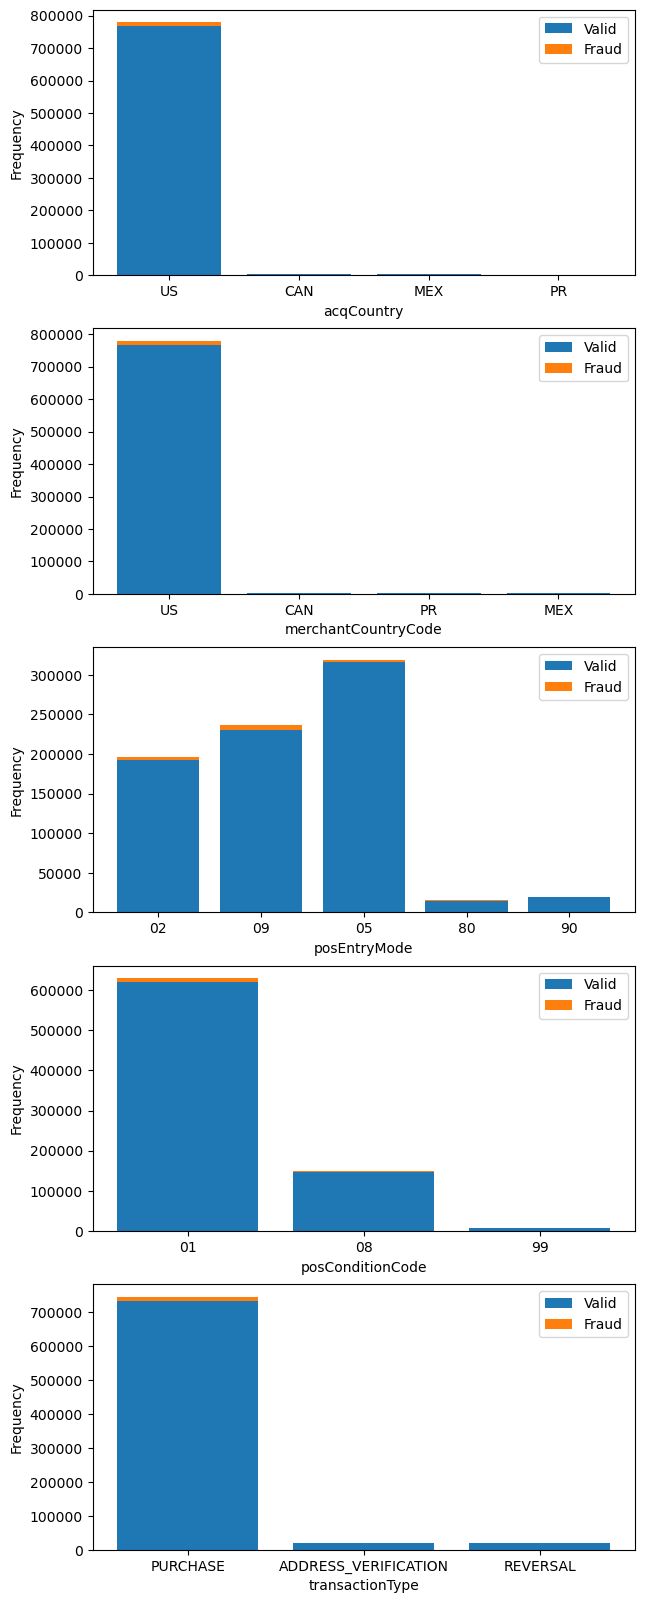

In [15]:
category=['acqCountry','merchantCountryCode','posEntryMode','posConditionCode','transactionType']

fig, axs = plt.subplots(nrows=5,figsize=(7,20))

for col,i in zip(category,range(len(category))):
    counts=card_txn.groupby([col,'isFraud'])['isFraud'].count()
    counts=counts.unstack(level=1)
    
    # Sort counts indices in the same order as unique values of the column
    counts = counts.loc[card_txn[col].unique()]

    axs[i].bar(card_txn[col].unique(),counts[False],bottom=None,label='Valid')
    axs[i].bar(card_txn[col].unique(),counts[True],bottom=counts[False],label='Fraud')
    axs[i].legend()
    axs[i].set_xlabel(col)
    axs[i].set_ylabel('Frequency')

## Continuous Variable

Let's visualize the continuous variable with stacked column chart

In [16]:
credit=card_txn[['accountNumber','creditLimit','availableMoney','transactionAmount','currentBalance','isFraud']]

def plot_distribution(dataframe, column, ax, bins_=50):
    """
    Plot variable distirbution in a stacked histogram of fraud/valid transactions
    """
    # Create a temporal dataframe with the data to be plot
    temp = pd.DataFrame({"No Fraud": dataframe[dataframe["isFraud"]==False][column],
    "Fraud":dataframe[dataframe["isFraud"]==True][column]})
    # Plot the histogram
    temp[["No Fraud","Fraud"]].plot(kind='hist', bins=bins_, ax=ax, stacked=True)
    # X-axis label
    ax.set_xlabel(column)
    # Change the x-axis to plain style
    ax.ticklabel_format(style='plain', axis='x')

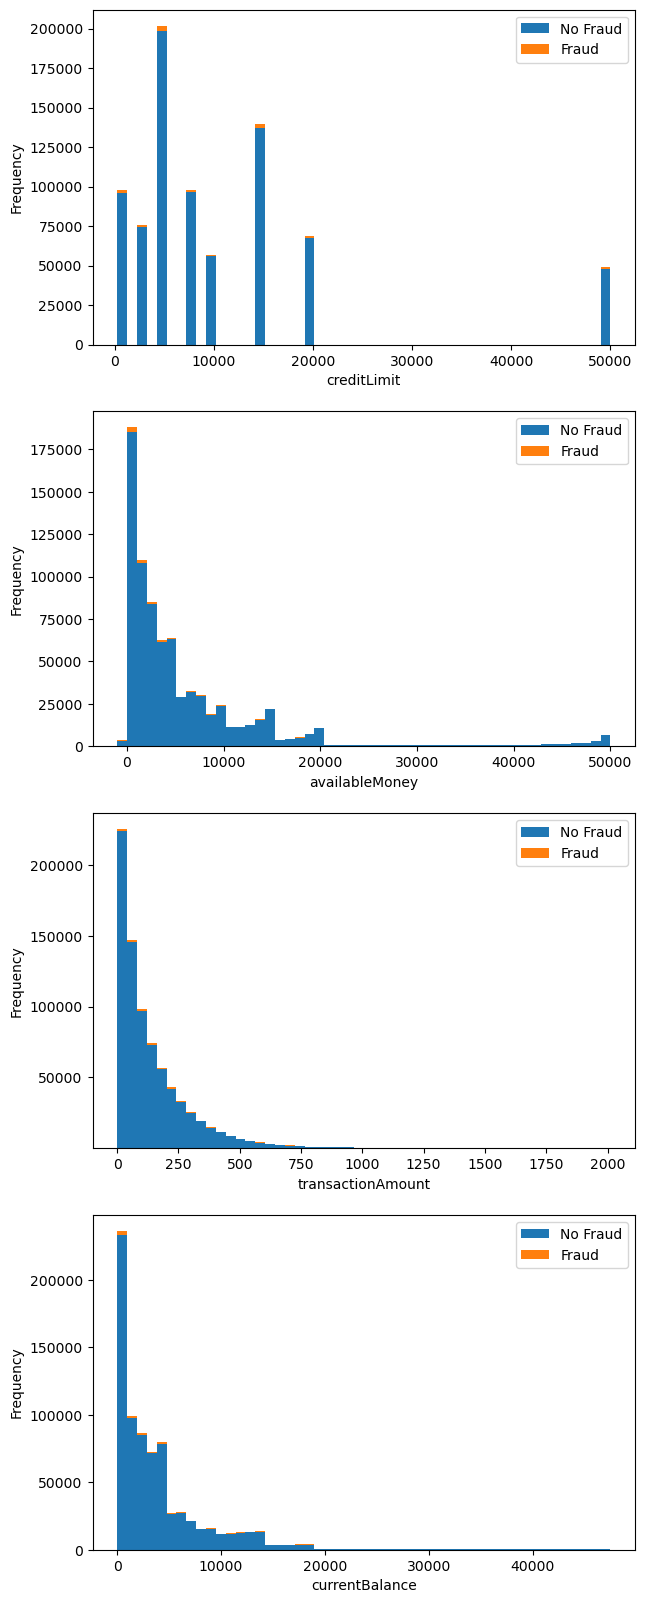

In [17]:
#plot each column with subplots
fig, axs = plt.subplots(nrows=4, figsize=(7, 20))

plot_distribution(credit, 'creditLimit', axs[0])
plot_distribution(credit, 'availableMoney', axs[1])
plot_distribution(credit, 'transactionAmount', axs[2])
plot_distribution(credit, 'currentBalance', axs[3])

In order to see the data distribution clearer, boxplots are needed.


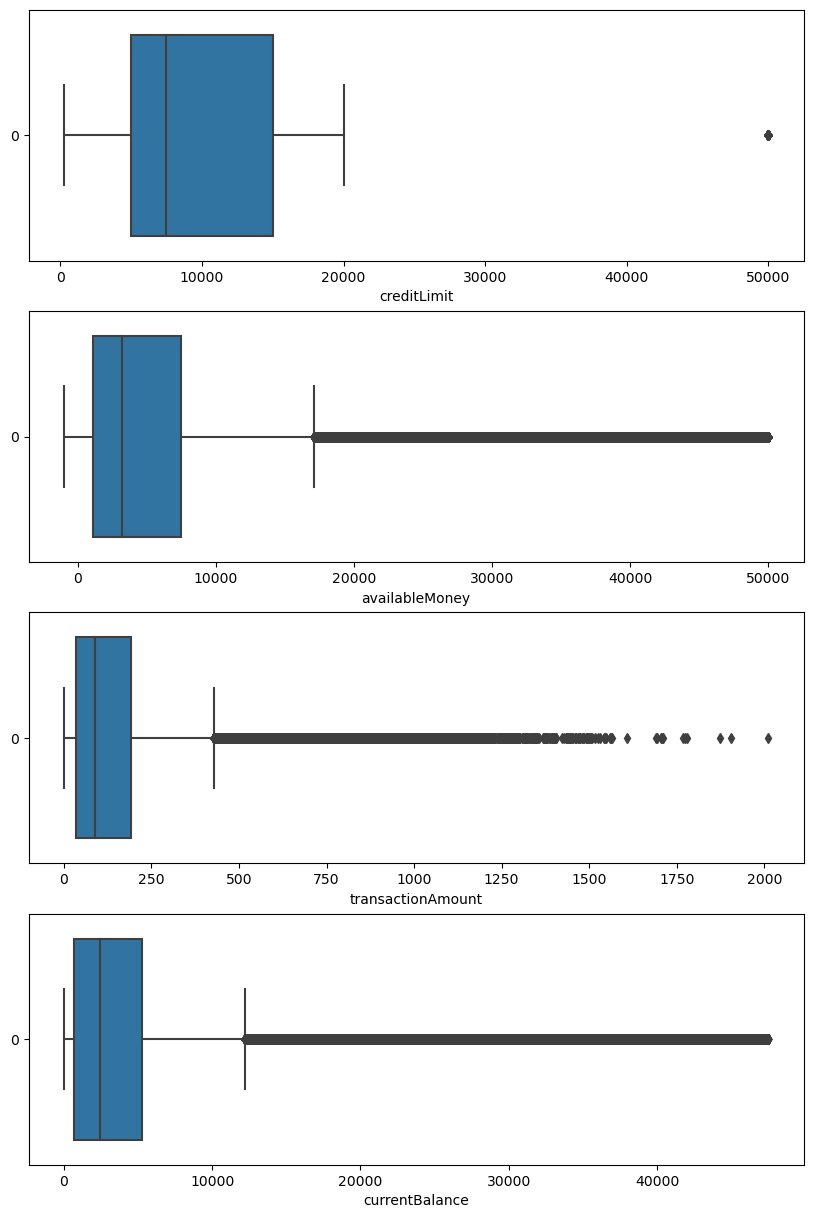

In [18]:
fig, axs = plt.subplots(nrows=4, figsize=(10,15))

# Plot boxplot
sns.boxplot(credit["creditLimit"], orient="h", ax=axs[0]).set(xlabel='creditLimit')
sns.boxplot(credit["availableMoney"], orient="h", ax=axs[1]).set(xlabel='availableMoney')
sns.boxplot(credit["transactionAmount"], orient="h", ax=axs[2]).set(xlabel='transactionAmount')
sns.boxplot(credit["currentBalance"], orient="h", ax=axs[3]).set(xlabel='currentBalance')

# Remove scientific notation
for ax in axs:
    ax.ticklabel_format(style='plain', axis='x')
    plt.show()

`creditLimit` has a multimodal distribution, where the other 3 are skewed to the right. The data range is quite wide, with a maximum balance, limit or available money from ~0 to 50,000 (except for `transactionAmount` with a ~$2,000 range.

We want to see the spending behavior of different credit limits.

Text(0, 0.5, 'Transaction Amount')

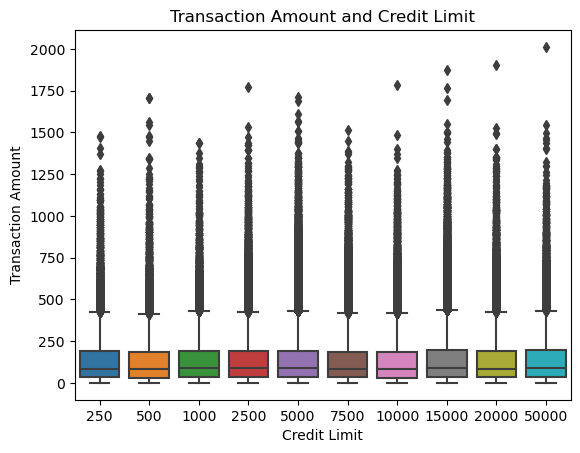

In [19]:
#boxplot for transactionAmount and creditLimit
sns.boxplot(data=card_txn, x='creditLimit', y='transactionAmount')
plt.title('Transaction Amount and Credit Limit')
plt.xlabel('Credit Limit')
plt.ylabel('Transaction Amount')


The spending behavior are pretty much uniform for all credit limit.

## `transactionAmount` histogram plot

array([[<AxesSubplot: title={'center': 'transactionAmount'}>]],
      dtype=object)

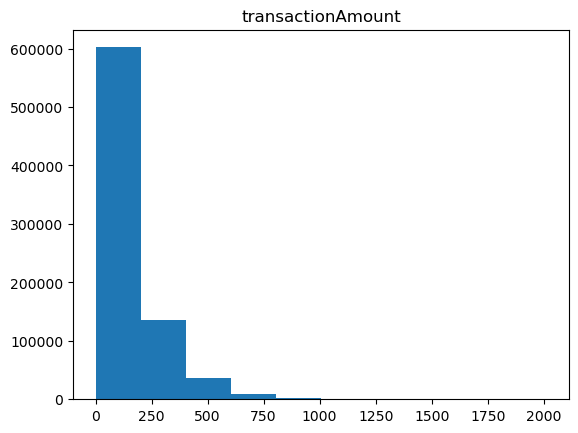

In [20]:
card_txn.hist(column='transactionAmount',grid=False)

Skewed to the right distribution, with a maximum amount of around $2,000. It is lower than my hypothesis where there are a lot of high credit profiles. 

Also, most amounts are under $500, which makes sense when people are not spending hundreds of dollars casually.

## Duplicate Transactions

Reversal transactions are marked with REVERSAL value in `transactionType`.

In [21]:
reversal=card_txn.loc[(card_txn['transactionType']=='REVERSAL')]

In [22]:
reversal.head(3)

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,currentExpDate,accountOpenDate,dateOfLastAddressChange,cardCVV,enteredCVV,cardLast4Digits,transactionType,currentBalance,cardPresent,expirationDateKeyInMatch,isFraud
39,574788567,574788567,2500,2200.98,2016-05-24 01:38:03,215.13,Convenient Tire,US,US,09,01,auto,2021-10-01,2015-10-13,2015-10-13,206,206,8522,REVERSAL,299.02,True,False,False
73,574788567,574788567,2500,2432.72,2016-10-07 10:23:57,3.87,Eazy Repair,US,US,05,01,auto,2022-10-01,2015-10-13,2015-10-13,579,579,4219,REVERSAL,67.28,True,False,False
101,924729945,924729945,50000,49831.43,2016-10-19 14:01:45,168.57,discount.com,US,US,05,01,online_retail,2024-11-01,2014-07-25,2014-07-25,205,265,9459,REVERSAL,168.57,False,False,False


In [23]:
print("There are", len(reversal), "reversal transactions worth of", f"${reversal['transactionAmount'].sum():,{'.2f'}}.")

There are 20303 reversal transactions worth of $2,821,792.50.


Multi-swipe transactions are the transactions charged to the same `customerId` from the same `merchantName`, within 2 minutes, and are also not reversal nor address verification (which has $0 values).

In [24]:
card_txn['Multi-Swipe']=(card_txn.sort_values(['transactionDateTime'])
                       .groupby(['customerId', 'transactionAmount','merchantName'], sort=False)['transactionDateTime']
                       .diff()
                       .dt.total_seconds()
                       .lt(120))

In [25]:
multi_swipe=card_txn.loc[(card_txn['Multi-Swipe'] == True) & 
                         (card_txn['transactionType']!='REVERSAL') & 
                         (card_txn['transactionType']!='ADDRESS_VERIFICATION')]

In [26]:
multi_swipe.head(3)

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,currentExpDate,accountOpenDate,dateOfLastAddressChange,cardCVV,enteredCVV,cardLast4Digits,transactionType,currentBalance,cardPresent,expirationDateKeyInMatch,isFraud,Multi-Swipe
263,984504651,984504651,50000,26680.99,2016-03-12 06:34:29,118.52,AMC #706324,US,US,02,01,entertainment,2024-10-01,2015-07-27,2015-07-27,640,640,8332,PURCHASE,23319.01,True,False,False,True
281,984504651,984504651,50000,24316.12,2016-03-18 13:57:04,26.71,Planet Fitness #692929,US,US,02,01,health,2024-10-01,2015-07-27,2015-07-27,640,640,8332,PURCHASE,25683.88,True,False,False,True
339,984504651,984504651,50000,16503.49,2016-04-08 22:21:11,43.21,WSC #994275,US,US,02,08,health,2030-02-01,2015-07-27,2016-03-26,640,640,8332,PURCHASE,33496.51,False,False,False,True


In [27]:
print("There are", len(multi_swipe), "multi-swipe transactions worth of", f"${multi_swipe['transactionAmount'].sum():,{'.2f'}}.")

There are 4921 multi-swipe transactions worth of $742,053.52.


In [28]:
reversal.to_csv('reversal.csv',index=False)
multi_swipe.to_csv('multi_swipe.csv',index=False)

### Analyzing `duplicate` dataframes

I expect some changes with the numerical variables, not the categorical when the values are too dominant. Let's see the statistical summary of both dataframes.

In [29]:
reversal.describe()

,accountNumber,customerId,creditLimit,availableMoney,transactionAmount,cardCVV,enteredCVV,cardLast4Digits,currentBalance
count,2.030300e+04,2.030300e+04,20303.000000,20303.000000,20303.000000,20303.000000,20303.000000,20303.000000,20303.000000
mean,5.358713e+08,5.358713e+08,10890.065508,6066.488049,138.984017,544.582623,544.331577,4746.035463,4823.577459
std,2.550463e+08,2.550463e+08,11731.251958,8731.066585,147.889733,262.936600,262.868166,3011.053090,6583.948171
min,1.000881e+08,1.000881e+08,250.000000,-440.580000,0.000000,100.000000,30.000000,0.000000,0.000000
25%,3.296389e+08,3.296389e+08,5000.000000,1071.730000,33.375000,308.000000,308.000000,2178.000000,886.570000
50%,4.986956e+08,4.986956e+08,7500.000000,3017.830000,92.010000,537.000000,536.000000,4733.000000,2803.480000
75%,7.676200e+08,7.676200e+08,15000.000000,7305.500000,192.980000,787.000000,787.000000,7343.000000,5815.565000
max,9.992836e+08,9.992836e+08,50000.000000,50000.000000,1435.640000,998.000000,998.000000,9998.000000,47470.790000


In [30]:
multi_swipe.describe()

,accountNumber,customerId,creditLimit,availableMoney,transactionAmount,cardCVV,enteredCVV,cardLast4Digits,currentBalance
count,4.921000e+03,4.921000e+03,4921.000000,4921.000000,4921.000000,4921.000000,4921.000000,4921.000000,4921.000000
mean,5.393591e+08,5.393591e+08,11013.818330,6045.686271,150.793237,540.231863,540.016866,4667.484048,4968.132059
std,2.537326e+08,2.537326e+08,11864.910651,8591.071105,151.863142,263.610447,263.675319,3012.518518,6851.239331
min,1.000881e+08,1.000881e+08,250.000000,-614.390000,0.120000,101.000000,40.000000,0.000000,0.000000
25%,3.401034e+08,3.401034e+08,5000.000000,1022.460000,42.560000,305.000000,305.000000,2062.000000,926.070000
50%,5.005057e+08,5.005057e+08,7500.000000,3067.780000,101.920000,531.000000,531.000000,4554.000000,2801.850000
75%,7.676200e+08,7.676200e+08,15000.000000,7401.320000,210.680000,782.000000,782.000000,7280.000000,5970.730000
max,9.992836e+08,9.992836e+08,50000.000000,49985.650000,1394.190000,998.000000,998.000000,9994.000000,47267.450000


We can see that not much changes from the numerical data either. I will visualize information about accounts, merchants, and their categories in Power BI.

## Modeling

As `isFraud` is binary, we will use classification models to predict whether a transaction is fraudulent or not.

### Feature Engineering

Let's create the following features: 
- `CVVMatch` to see if `enteredCVV` is the same as `cardCVV`
- `isLast4Digits` to see if the `cardLast4Digits` actually has 4 digits. Based on the summary table above we can see some 0 values
- `isCardExpire` to see if the `transactionDateTime` is after `currentExpDate`
- `accountAge`, duration from `accountOpenDate` to `transactionDateTime`
- `sinceLastAddressChange`, duration from `accountOpenDate` to `transactionDateTime`

I believe these are important features to determine frauds, and they also help bring down the dataset dimension.

In [31]:
card_txn["CVVMatch"] = np.where(card_txn["cardCVV"] == card_txn["enteredCVV"], True, False)
card_txn["isLast4Digits"]=np.where(card_txn['cardLast4Digits'].astype(str).str.len()==4,True,False)
card_txn['isCardExpire']=np.where(card_txn['currentExpDate']<card_txn['transactionDateTime'],True,False)
card_txn["accountAge"]=((card_txn['transactionDateTime']-card_txn['accountOpenDate']).dt.total_seconds())/(365.2425*24*60*60)
card_txn["sinceLastAddressChange"]=((card_txn['transactionDateTime']-card_txn['dateOfLastAddressChange']).dt.total_seconds())/(365.2425*24*60*60)

Drop `enteredCVV`,`cardCVV`, `cardLast4Digits`, `transactionDateTime`,`currentExpDate`, and `accountOpenDate` after creating new features.

In [32]:
card_txn=card_txn.drop(["customerId","cardCVV","enteredCVV","cardLast4Digits","accountOpenDate",
               "currentExpDate","transactionDateTime","dateOfLastAddressChange"],axis=1)

Since those models only take numerical values, let's transform the non-numerical data into ones.

### Data Preprocessing

In [33]:
#Label Encoding data to turn non-numerical data into numerical
var=['merchantName','acqCountry','merchantCountryCode','posEntryMode','posConditionCode',
     'merchantCategoryCode','transactionType','cardPresent','expirationDateKeyInMatch',
     'isFraud','CVVMatch','Multi-Swipe','isLast4Digits','isCardExpire']
for i in var:
    card_txn[i]=LabelEncoder().fit_transform(card_txn[i])

Since the data is imbalanced, we will perform undersampling on it. This is the data before and after undersampling.

Text(0, 0.5, 'Frequency')

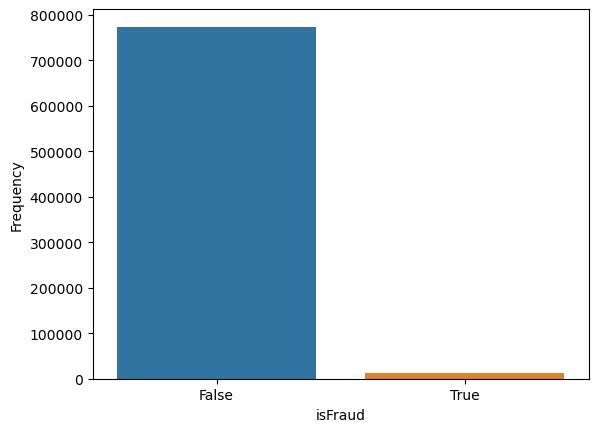

In [34]:
#Plot original data counts for fraud and valid transactions
sns.barplot(x=[0,1],y=card_txn['isFraud'].value_counts())
plt.xticks(ticks=[0,1],labels=['False','True'])
plt.xlabel('isFraud')
plt.ylabel('Frequency')

In [35]:
#Undersampling
isFraud=card_txn['isFraud']
card_txn.drop('isFraud', inplace=True, axis=1)
X, y = RandomUnderSampler().fit_resample(card_txn, isFraud)

Text(0, 0.5, 'Frequency')

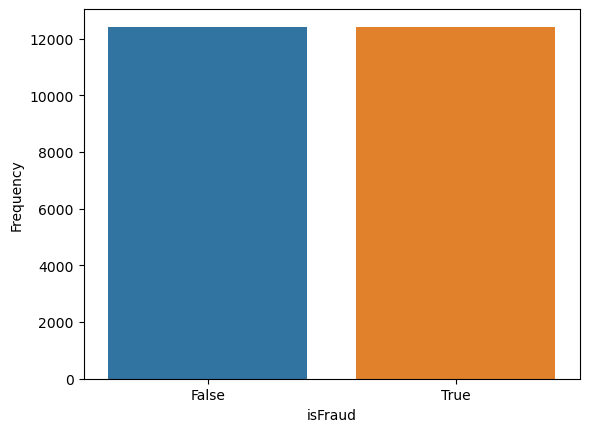

In [36]:
#Plot after-sampled data counts for fraud and valid transactions
sns.barplot(x=[0,1],y=y.value_counts())
plt.xticks(ticks=[0,1],labels=['False','True'])
plt.xlabel('isFraud')
plt.ylabel('Frequency')

Next would be checking the multicollinearity during the features and considering dropping those.

In [37]:
# VIF (Variable Inflation Factors) for multicollinearity detection
def calc_vif(X):
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [format(variance_inflation_factor(X.values, i),'.0f') for i in range(X.shape[1])]

    return(vif)

In [38]:
calc_vif(X)

,variables,VIF
0,accountNumber,6
1,creditLimit,inf
2,availableMoney,inf
3,transactionAmount,2
4,merchantName,5
5,acqCountry,12384
6,merchantCountryCode,12316
7,posEntryMode,3
8,posConditionCode,1
9,merchantCategoryCode,11


We can see here that the `creditLimit`, `availableMoney`, `acqCountry`,`merchantCountryCode`, `currentBalance`,`cardCVV`, `merchantCategoryCode`, `transactionType`,`currentBalance` and `CVVMatch` have a high VIF value, meaning they can be predicted by other independent variables in the dataset; and they usually goes by pair with each other.

`isCardExpire` are having nan value - its statistical summary may be invalid. 

Dropping some of these will help in bringing down the multicollinearity between correlated features.

In [39]:
X.drop(['availableMoney','acqCountry'],axis=1,inplace=True)
X.drop(['merchantCountryCode','CVVMatch'],axis=1,inplace=True)
X.drop(['isCardExpire'],axis=1,inplace=True)
X.drop(['transactionType'],axis=1,inplace=True)

calc_vif(X)

,variables,VIF
0,accountNumber,5
1,creditLimit,3
2,transactionAmount,2
3,merchantName,5
4,posEntryMode,3
5,posConditionCode,1
6,merchantCategoryCode,8
7,currentBalance,3
8,cardPresent,2
9,expirationDateKeyInMatch,1


Now we are ready to split the data into training and testing, by using Skicit-learn

In [40]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, test_size = 0.2, random_state = 42)

In [41]:
#printing the confusion matrix and evals metrics
def evals(y_test,y_pred):
    #confusion matrix
    label = ['Valid', 'Fraud']
    conf_matrix = confusion_matrix(y_test, y_pred)
    plt.figure()
    sns.heatmap(conf_matrix, xticklabels=label, yticklabels=label, annot=True, fmt='d');
    plt.title('Confusion Matrix')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

    #metrics
    acc=accuracy_score(y_test,y_pred)
    print('Accuracy: {}'.format(acc))
    prec=precision_score(y_test,y_pred)
    print('Precision: {}'.format(prec))
    rec=recall_score(y_test,y_pred)
    print('Recall: {}'.format(rec))
    f1=f1_score(y_test,y_pred)
    print('F1-Score: {}'.format(f1))
    bal_acc=balanced_accuracy_score(y_test,y_pred)
    print('Balanced Accuracy: {}'.format(bal_acc))

We will use 5 algorithms for this model: 
- Decision Tree
- Logistic Regression
- Random Forest
- KNN
- XG-Boost

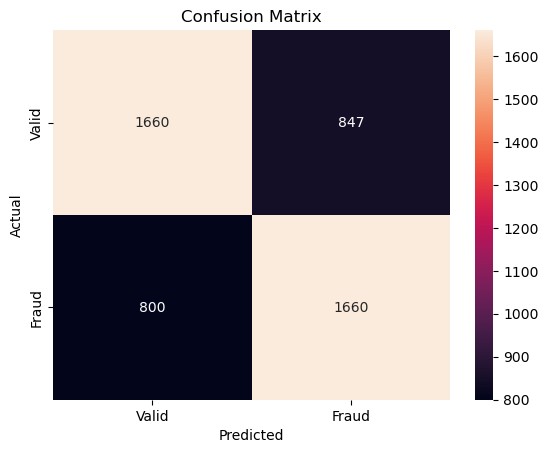

Accuracy: 0.6684115160056372
Precision: 0.6621459912245712
Recall: 0.6747967479674797
F1-Score: 0.6684115160056373
Balanced Accuracy: 0.6684713695960254


In [42]:
#Gini Decision Tree
clf_gini=DecisionTreeClassifier()
clf_gini.fit(X_train,y_train)
y_pred=clf_gini.predict(X_test)
y_pred_prob=clf_gini.predict_proba(X_test)[:,1]

dec_tree=[y_test,y_pred_prob]

evals(y_test,y_pred)

Not a good model, with accuracy of around 66%.

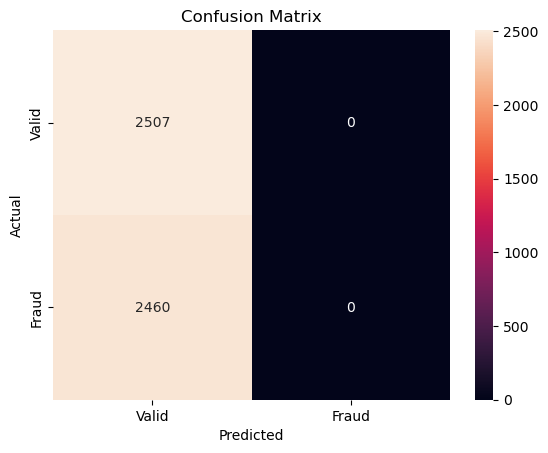

Accuracy: 0.5047312260922086
Precision: 0.0
Recall: 0.0
F1-Score: 0.0
Balanced Accuracy: 0.5


In [43]:
#Logistic Regression
lr = LogisticRegression()
lr.fit(X_train, y_train)
y_pred=lr.predict(X_test)
y_pred_prob=lr.predict_proba(X_test)[:,1]

log_reg=[y_test,y_pred_prob]

evals(y_test,y_pred)

With precision and recall = 0:

The model is not able to identify any actual fraudulent transactions. Instead, incorrectly captures legitimate transactions as fraudulent 


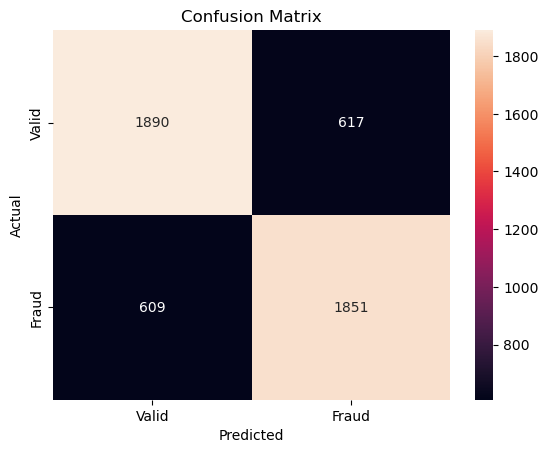

Accuracy: 0.7531709281256291
Precision: 0.75
Recall: 0.7524390243902439
F1-Score: 0.7512175324675324
Balanced Accuracy: 0.7531640674404351


In [44]:
#Random Forest
rf=RandomForestClassifier()
rf.fit(X_train,y_train)
y_pred=rf.predict(X_test)
y_pred_prob=rf.predict_proba(X_test)[:,1]

random_forest=[y_test,y_pred_prob]

evals(y_test,y_pred)

Relatively good performance, does not go against my hypothesis that Random Forest will be one of the best model

By far the best model


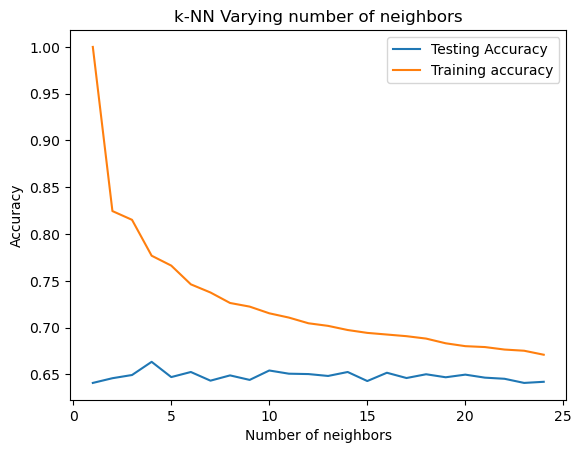

In [45]:
#KNN
neighbors = np.arange(1,25)
train_accuracy =np.empty(len(neighbors))
test_accuracy = np.empty(len(neighbors))

for i,k in enumerate(neighbors):
    #Setup a knn classifier with k neighbors
    knn=KNeighborsClassifier(n_neighbors=k,algorithm="kd_tree",n_jobs=-1)
    
    #Fit the model
    knn.fit(X_train,y_train.ravel())
    
    #Compute accuracy on the training set
    train_accuracy[i] = knn.score(X_train, y_train.ravel())
    
    #Compute accuracy on the test set
    test_accuracy[i] = knn.score(X_test, y_test.ravel()) 

#Generate plot
plt.title('k-NN Varying number of neighbors')
plt.plot(neighbors, test_accuracy, label='Testing Accuracy')
plt.plot(neighbors, train_accuracy, label='Training accuracy')
plt.legend()
plt.xlabel('Number of neighbors')
plt.ylabel('Accuracy')
plt.show()

[4]


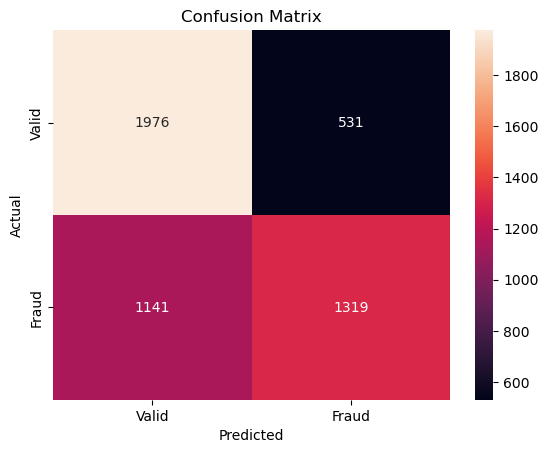

Accuracy: 0.6633782967586068
Precision: 0.712972972972973
Recall: 0.5361788617886178
F1-Score: 0.6120649651972158
Balanced Accuracy: 0.6621859606111019


In [46]:
idx = np.where(test_accuracy == max(test_accuracy))
x = neighbors[idx]
print(x)
knn=KNeighborsClassifier(n_neighbors=x[0],algorithm="kd_tree",n_jobs=-1)
knn.fit(X_train,y_train.ravel())
y_pred=knn.predict(X_test)
y_pred_prob=knn.predict_proba(X_test)[:,1]

KNN=[y_test,y_pred_prob]

evals(y_test,y_pred)


Not a good model, as it can only identify 54% positives of all actual positive instances (recall = 54%)

Models are missing out fraudulent transactions 


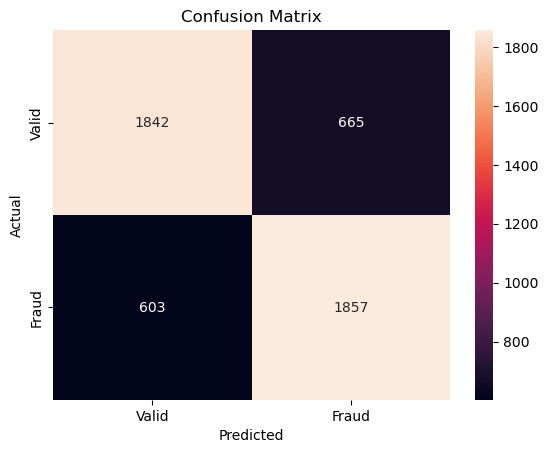

Accuracy: 0.7447151197906181
Precision: 0.7363203806502776
Recall: 0.7548780487804878
F1-Score: 0.7454837414692894
Balanced Accuracy: 0.7448103845817078


In [47]:
#XG Boost
xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=42)
xgb_model.fit(X_train,y_train)
y_pred = xgb_model.predict(X_test)
y_pred_prob=xgb_model.predict_proba(X_test)[:,1]

xgb_mod=[y_test,y_pred_prob]

evals(y_test,y_pred)

Accuracy is a bit less than Random Forest

Second best model by far 


In [48]:
def roc(models):
    for key, value in models.items():
        fpr, tpr, _ = roc_curve(value[0],value[1])
        sns.lineplot(x=fpr, y=tpr, label=key)

    ax = sns.lineplot(x=[0, 0.5, 1], y=[0, 0.5, 1])
    ax.lines[len(models)].set_linestyle("--")
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve')

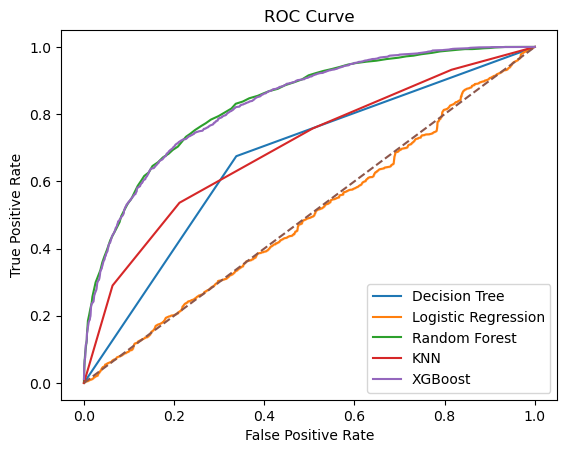

In [49]:
model_results = {
    'Decision Tree': dec_tree,
    'Logistic Regression': log_reg,
    'Random Forest': random_forest,
    'KNN': KNN,
    'XGBoost': xgb_mod
}
roc(model_results)


We are having a close competition between Random Forest and XGBoost.

[0.11139026 0.07545326 0.16223413 0.12759904 0.06295483 0.0183761
 0.07120862 0.10662657 0.02818034 0.00062468 0.00362162 0.01197358
 0.1125925  0.10716448]


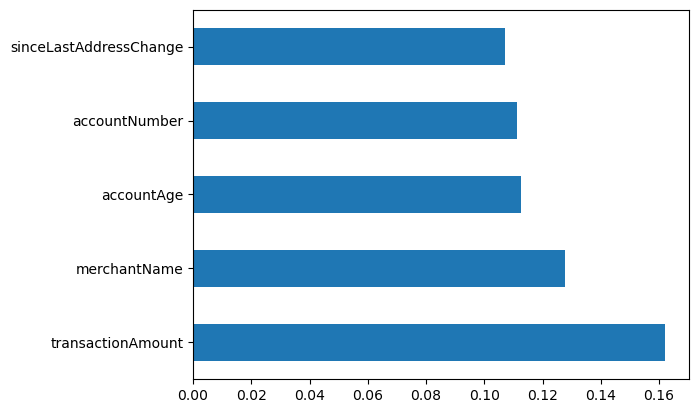

In [50]:
# Feature Importance Visualization
model=ExtraTreesClassifier(n_estimators=100)
model.fit(X,y)
print(model.feature_importances_)

#plotting
f_i=pd.Series(model.feature_importances_,index=X.columns)
f_i.nlargest(5).plot(kind='barh')
plt.show()

`transactionAmount` and `merchantName` are the top 2 most important feature for modeling.